In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from scipy import optimize
from scipy.linalg import det
import sys
sys.path.append('../')

from scripts.compute_covariance import compute_covariance

In [2]:
nside=256
npix=hp.nside2npix(nside)
freqs=np.arange(544,1088,step=10)
nfreqs=len(freqs)-1
lmax=3*nside -1
almsize=hp.Alm.getsize(lmax)

In [3]:
cl_hi_1=np.load("/home/iloveorcas/MASS_Thesis/HI/cal_hi_cov.npy")
cl_hi = np.transpose(cl_hi_1, (2, 0, 1))
hi_maps= np.load("HI_map_cal.npy")

In [4]:
def bin_spectra(cl, delta):
    b= nmt.NmtBin.from_lmax_linear(lmax, nlb=delta)
    n_bins = b.get_n_bands()
    leff = b.get_effective_ells()
    cl_binned= np.zeros((n_bins, nfreqs, nfreqs))

    for i in range(nfreqs):
        for j in range(nfreqs):
            cl_binned[:, i, j] = b.bin_cell(cl[:, i, j])
            
    return leff,n_bins,cl_binned

In [5]:
leff, nbins,hi_binned= bin_spectra(cl_hi, 10)
# *_,noise_binned= bin_spectra(cl_noise, 10)
# *_, fgds_binned= bin_spectra(cl_fgds, 10)
# total=hi_maps + noise_maps[:54]
# cl_hat=compute_covariance(total, lmax, almsize, nfreqs)
# *_, chat_binned= bin_spectra(cl_hat, 10)

In [6]:
def diagonalize_matrices(cl, nfreqs):
    cl_diag=np.zeros((nbins, nfreqs, nfreqs))
    for l in range (nbins):
        #print(f"Diagonalizing matrix {l}")
        cl_diag[l,:,:]= np.identity(nfreqs)*cl[l,:,:]
    return cl_diag
hi_d= diagonalize_matrices(hi_binned, nfreqs)
#print(hi_d[10])

In [47]:
bins=10

In [48]:
def build_trapezoidal_basis(freqs, bin, top_width=0.5):
    """
    Create trapezoidal basis functions (___/----\___) on frequency grid.
    
    Parameters:
    - freqs: 1D array of frequency bin centers (nf,)
    - n_bins: number of trapezoidal functions (i.e., nq)
    - top_width: fraction of bin width used for the flat top (0 < top_width < 1)

    Returns:
    - phi: shape (n_bins, nf), the basis matrix
    """
    nf = len(freqs)
    vmin, vmax = freqs[0], freqs[-1]
    bin_edges = np.linspace(vmin, vmax, bins + 1)
    bin_width = bin_edges[1] - bin_edges[0]
    flat_top = top_width * bin_width
    slope_width = (1 - top_width) * bin_width / 2  #slope= 1/slope_width

    phi = np.zeros((bin, nf))

    for i in range(bin):
        # Define edges of the trapezoid
        left = bin_edges[i] - slope_width
        start_flat = bin_edges[i]
        end_flat = bin_edges[i + 1]
        right = bin_edges[i + 1] + slope_width

        for j, v in enumerate(freqs):
            if left <= v < start_flat:
                phi[i, j] = (v - left) / slope_width
            elif start_flat <= v <= end_flat:
                phi[i, j] = 1.0
            elif end_flat < v <= right:
                phi[i, j] = (right - v) / slope_width
            else:
                phi[i, j] = 0.0

    return phi


Building the parametric HI model

In [49]:
from itertools import product
from numpy.linalg import lstsq

P, Q = 5,bins-1  #degree
v0=freqs[23]
n=0.5

# Step 1: Extract diagonal
nell, nf, _ = hi_d.shape
C_diag = np.array([np.diag(hi_d[i]) for i in range(nell)])  # shape (nell, nf)

# Step 2: Log coordinates
log_l = np.log10(leff)  # shape (nell,)
log_v = np.log10(freqs[:-1])  # shape (nf,)
scaling = (freqs[:-1] / v0)**(-n)  # shape (nf,)

# Step 3: Build hat-shaped basis
phi = build_trapezoidal_basis(freqs[:-1], bins)  # shape (nq, nf)
# Unnormalized Psi: each row is φ_q(v) * scaling
Psi_unnorm = phi * scaling[None, :]  # shape (nq, nf)

# Normalize across q (rows) for each v (column)
Psi = Psi_unnorm / Psi_unnorm.sum(axis=0, keepdims=True)
print(Psi.shape)# shape (nq, nf)
# Psi = phi * scaling[None, :]              # shape (nq, nf)

# Step 4: Build coeff matrix
basis_terms = list(product(range(P + 1), range(Q + 1))) # all (p, q) pairs (0,0), (0,1), ..., (P,Q)
n_terms = len(basis_terms) # total number of basis functions (P + 1) * (Q + 1)

X = np.zeros((nell * nf, n_terms))# rows = data points, cols = basis terms
y = C_diag.reshape(-1) #flatten target values to shape (nell * nf,)
print(y.shape)
print(len(leff)*nf)

for i, (p, q) in enumerate(basis_terms):
    # Outer product: (nell,) x (nf,) → shape (nell, nf)
    X[:, i] = np.outer(log_l**p, Psi[q,:]).reshape(-1)

# Step 5: Solve least mean squares
a_vec, residuals, rank, s = lstsq(X, y, rcond=471256)
a_vec=a_vec/np.linalg.norm(a_vec)
a_matrix = a_vec.reshape((P + 1, Q + 1))  # shape (P+1, Q+1)
print(a_matrix.shape)
print(a_vec.shape)

# Step 6: Reconstruct the fitted diagonal
C_fit_diag = np.zeros((nell, nf))
for p in range(P + 1):
    for q in range(Q + 1):
        C_fit_diag +=a_matrix[p, q] * np.outer(log_l**p, Psi[q])

# Step 7: Expand to full (nell, nf, nf) with diagonal only
C_fit = np.zeros((nell, nf, nf))
for i in range(nell):
    np.fill_diagonal(C_fit[i], C_fit_diag[i])


(10, 54)
(4104,)
4104
(6, 10)
(60,)


In [624]:
s[0]/s[-1]

np.float64(471256.10212028545)

In [50]:
def loss(a):
    a_mat = a.reshape((P + 1, Q + 1))  # reshape into coefficient matrix
    C_model = np.zeros((nell, nf))    # predicted covariance diagonal
    for p in range(P + 1):
        for q in range(Q + 1):
            C_model += a_mat[p, q] * np.outer(log_l**p, Psi[q])
    r = ((C_model - C_fit_diag)).reshape(-1)   #/np.linalg.norm(C_fit_diag)).reshape(-1)  # residual
    # r=X @ a - y  # residual vector
    return 0.5* np.dot(r, r)           # MSE

def grad_loss(a):
    a_mat = a.reshape((P + 1, Q + 1))
    C_model = np.zeros((nell, nf))
    for p in range(P + 1):
        for q in range(Q + 1):
            C_model += a_mat[p, q] * np.outer(log_l**p, Psi[q])
    r = (C_model - C_fit_diag)

    grad = np.zeros_like(a_mat)
    for p in range(P + 1):
        log_term = log_l**p  # shape (nell,)
        for q in range(Q + 1):
            psi_term = Psi[q]  # shape (nf,)
            grad[p, q] = np.sum(r * np.outer(log_term, psi_term))
    # grad= X.T @ r.reshape(-1)
    return grad.reshape(-1)

In [51]:
grad_loss(a_vec)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [86]:
from scipy.optimize import minimize

res1 = minimize(loss,3*a_vec,
               jac=grad_loss,
               method='BFGS',
               options={'disp': True, 'maxls':10000, 'maxfun': 600000,'ftol': 1e-12,'gtol': 1e-1, 'maxiter': 12000}) #, 'maxls':100,'xtol': 1e-15, 'gtol': 1e-15, 'verbose': 2

a_opt1 = res1.x.reshape((P+1, Q+1))

Optimization terminated successfully.
         Current function value: 0.000102
         Iterations: 43
         Function evaluations: 76
         Gradient evaluations: 76


/tmp/ipykernel_347584/369093680.py:3: OptimizeWarning: Unknown solver options: maxls, maxfun, ftol
  res1 = minimize(loss,3*a_vec,


In [87]:
from pprint import pprint

pprint(res1)


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.00010245530162375591
        x: [ 3.629e-01  3.253e-01 ... -2.026e-04 -4.882e-05]
      nit: 43
      jac: [-1.305e-04 -3.134e-05 ...  1.360e-03 -7.693e-03]
 hess_inv: [[ 7.018e+00  1.754e+00 ... -1.345e-02 -7.233e-03]
            [ 1.754e+00  1.210e+00 ... -3.596e-03 -1.647e-03]
            ...
            [-1.345e-02 -3.596e-03 ...  7.834e-03 -2.979e-05]
            [-7.233e-03 -1.647e-03 ... -2.979e-05  7.701e-03]]
     nfev: 76
     njev: 76


In [88]:
freqs[26]

np.int64(804)

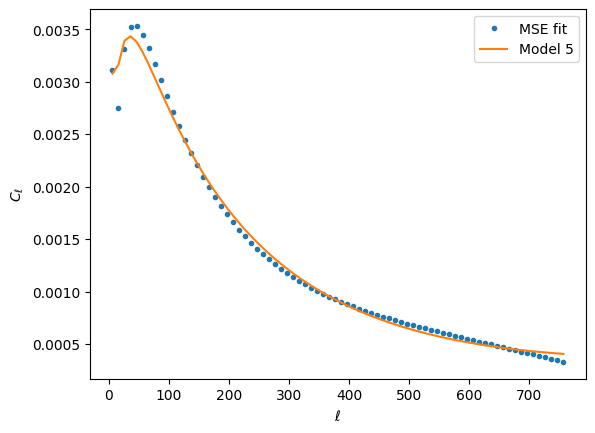

In [135]:
a_new = a_opt1.reshape((P+1, Q+1))
C_new = np.zeros((nell, nf))
for p in range(P + 1):
    for q in range(Q + 1):
        C_new += (a_new[p, q]) * np.outer(log_l**p, Psi[q])



plt.plot( leff,C_new[:,26], '.',label='MSE fit')
plt.plot( leff,C_fit_diag[:,26], label='Model 5')
plt.ylabel('$C_{\ell}$')
plt.xlabel('$\ell$')
plt.legend()

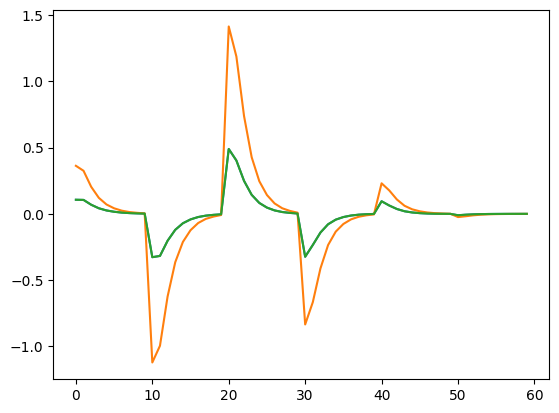

In [95]:
plt.plot(a_vec)
plt.plot(res1.x)
plt.plot(res2.x)

In [61]:
U,D,Vt=np.linalg.svd(X, full_matrices=False)
# U.shape
X_test=U@ np.diag(D) @Vt
a_svd=Vt.T @ np.linalg.inv(np.diag(D)) @ U.T @ (X@a_vec)
a_svd

array([ 1.06538318e-01,  1.05369421e-01,  6.89700217e-02,  4.22591442e-02,
        2.57841709e-02,  1.59039984e-02,  9.63953732e-03,  5.84425690e-03,
        3.64073759e-03,  2.06273288e-03, -3.27045683e-01, -3.17631897e-01,
       -2.02770549e-01, -1.20498083e-01, -7.09163266e-02, -4.18360530e-02,
       -2.38828926e-02, -1.33770044e-02, -7.48679304e-03, -3.46460284e-03,
        4.89892778e-01,  4.02934193e-01,  2.49386232e-01,  1.43669643e-01,
        8.24309080e-02,  4.72909878e-02,  2.60471531e-02,  1.38971936e-02,
        7.23433396e-03,  2.81305464e-03, -3.23710082e-01, -2.34810056e-01,
       -1.40940408e-01, -7.84456806e-02, -4.35759567e-02, -2.40349095e-02,
       -1.25161864e-02, -6.12570591e-03, -2.72779929e-03, -5.69308974e-04,
        9.51590801e-02,  6.31092304e-02,  3.67685507e-02,  1.97117486e-02,
        1.05126797e-02,  5.48490918e-03,  2.60840772e-03,  1.07479271e-03,
        2.93727369e-04, -1.69852693e-04, -1.02981808e-02, -6.38124947e-03,
       -3.61152407e-03, -

In [62]:
from numpy.linalg import slogdet, inv
# Example: equal weight for each ell bin
n_q = np.ones(nbins)  

# Or: number of modes in each ell bin
n_q = np.array([sum(2*l + 1 for l in range(nbins)) 
                for b in range(nbins)])

y_1=(X_test@a_svd).reshape((nell, nf))
C_y = np.zeros((nell, nf, nf))
for i in range(nell):
    np.fill_diagonal(C_y[i], np.maximum(y_1[i], 1e-6))
    

def build_C_model(a):
    # a_mat = a.reshape((P + 1, Q + 1))  # reshape into coefficient matrix
    # C_model = np.zeros((nell, nf))    # predicted covariance diagonal
    # for p in range(P + 1):
    #     for q in range(Q + 1):
    #         C_model += a_mat[p, q] * np.outer(log_l**p, Psi[q])
    C_model=(X_test @a).reshape((nell, nf))
    C_model_full = np.zeros((nell, nf, nf))
    for i in range(nell):
        np.fill_diagonal(C_model_full[i], C_model[i])

    return C_model_full


def smica_loss(a):
    
    loss = 0.0
    C_model = build_C_model(a)
    
    for b in range(nbins):
        C_emp = C_y[b] + 1e-6 * np.eye(nfreqs) # empirical HI covariance at that b
        C_mod = C_model[b] + 1e-6 * np.eye(nfreqs)

        # sign, logdet = slogdet(C_emp @ np.linalg.inv(C_mod))
        sign_emp, logdet_emp = slogdet(C_emp)
        sign_mod, logdet_mod = slogdet(C_mod)
        # if sign_emp <= 0 or sign_mod <= 0:
        #     return np.inf  # not positive definite
        logdet = logdet_emp - logdet_mod
        
        # if sign <= 0:
        #     return np.inf  # invalid logdet => reject this parameter set
        trace_term = np.trace(C_emp @ np.linalg.inv(C_mod))
        loss +=  (trace_term - logdet - nfreqs)
    return loss


def jacobian(a):

    C_model = build_C_model(a)  # shape (nell, nf, nf)
    grad = np.zeros((P+1, Q+1))

    for b in range(nbins):
        C_emp = C_y[b]       # empirical (nf, nf)
        C_mod = C_model[b] 
      # model (nf, nf)
        C_mod_inv = np.linalg.inv(C_mod)

        Delta = C_mod_inv - C_mod_inv @ C_emp @ C_mod_inv  # (nf, nf)
        

        for p in range(P+1):
            for q in range(Q+1):
                dR = np.zeros_like(C_mod)
                diag_val = (log_l[b]**p) * Psi[q]  # length nf
                np.fill_diagonal(dR, diag_val)
                grad[p, q] += np.trace(Delta @ dR)  # multiply by n_q[b] if needed

    return grad.reshape(-1)

jacobian(res1.x)

array([-1.04408303e+04, -2.54476820e+04, -2.62888051e+04, -1.61669955e+04,
       -1.46557048e+04, -8.87135150e+03, -7.76862736e+03, -4.15168283e+03,
       -2.82557706e+03, -2.08763857e+03, -3.01344429e+04, -7.33601064e+04,
       -7.59491110e+04, -4.68930230e+04, -4.28415402e+04, -2.61281053e+04,
       -2.30095676e+04, -1.25184889e+04, -8.49829888e+03, -6.76415212e+03,
       -8.70919531e+04, -2.11710484e+05, -2.19726703e+05, -1.36454212e+05,
       -1.25469700e+05, -7.72522220e+04, -6.84291195e+04, -3.78214927e+04,
       -2.57798081e+04, -2.14171705e+04, -2.51956853e+05, -6.11424019e+05,
       -6.36202642e+05, -3.97668761e+05, -3.67739505e+05, -2.28690941e+05,
       -2.03671207e+05, -1.14217934e+05, -7.82971437e+04, -6.67947448e+04,
       -7.29409253e+05, -1.76661152e+06, -1.84286028e+06, -1.15962607e+06,
       -1.07780581e+06, -6.76863274e+05, -6.05702232e+05, -3.44263725e+05,
       -2.37309440e+05, -2.06271889e+05, -2.11253740e+06, -5.10568243e+06,
       -5.33908854e+06, -

In [76]:
from scipy.optimize import minimize

res2 = minimize(smica_loss,res1.x,
               jac=jacobian,
               method='BFGS',
               options={'disp': True, 'maxfun': 600000,'ftol': 1e-5, 'maxls':100000, 'gtol': 1e-1, 'maxiter': 12000}) #, 'maxls':100,'xtol': 1e-15, 'gtol': 1e-15, 'verbose': 2

a_opt2 = res2.x.reshape((P+1, Q+1))

/tmp/ipykernel_347584/2242924006.py:3: OptimizeWarning: Unknown solver options: maxfun, ftol, maxls
  res2 = minimize(smica_loss,res1.x,


Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 75
         Function evaluations: 90
         Gradient evaluations: 90


In [77]:
from pprint import pprint

pprint(res2)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -1.7834622667578515e-12
        x: [ 1.065e-01  1.054e-01 ...  1.543e-05  5.056e-05]
      nit: 75
      jac: [-4.131e-05 -7.828e-06 ... -6.857e-03 -4.984e-03]
 hess_inv: [[ 1.479e-01 -1.000e-02 ...  9.693e-07  2.245e-06]
            [-1.005e-02  4.654e-02 ...  1.897e-06 -5.796e-07]
            ...
            [ 1.037e-06  1.673e-06 ...  1.024e-06 -7.230e-08]
            [ 2.145e-06 -4.673e-07 ... -7.196e-08  5.320e-07]]
     nfev: 90
     njev: 90


In [78]:
res2.x/a_vec

array([1.        , 0.99999999, 1.        , 0.99999998, 1.00000003,
       0.99999998, 1.00000001, 1.00000002, 0.99999997, 0.99999999,
       1.        , 0.99999999, 1.        , 0.99999998, 1.00000003,
       0.99999997, 1.00000001, 1.00000003, 0.99999996, 0.99999999,
       1.        , 1.        , 1.        , 0.99999998, 1.00000003,
       0.99999997, 1.00000001, 1.00000004, 0.99999995, 0.99999999,
       1.        , 1.        , 1.        , 0.99999998, 1.00000002,
       0.99999997, 1.00000001, 1.00000005, 0.99999993, 0.99999997,
       1.        , 1.        , 1.        , 0.99999999, 1.00000002,
       0.99999997, 1.00000001, 1.00000007, 0.99999984, 1.00000002,
       1.        , 1.        , 1.        , 0.99999999, 1.00000002,
       0.99999996, 1.00000002, 1.00000015, 1.0000003 , 1.        ])

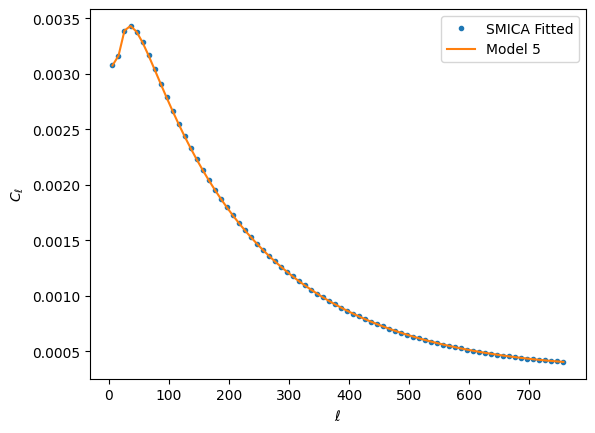

In [136]:
f=26
a_smica= a_opt2.reshape((P+1, Q+1))
C_smica= np.zeros((nell, nf))
for p in range(P + 1):
    for q in range(Q + 1):
        C_smica += (a_smica[p, q]) * np.outer(log_l**p, Psi[q])



plt.plot(leff, C_smica[:,f], '.',label='SMICA Fitted')
plt.plot(leff, C_fit_diag[:,f], label='Model 5')
plt.ylabel('$C_{\ell}$')
plt.xlabel('$\ell$')
plt.legend()

### EXTRAA

In [641]:
from scipy.optimize import approx_fprime

a_test = np.random.randn((P+1)*(Q+1))
eps = np.sqrt(np.finfo(float).eps)

grad_fd = approx_fprime(a_vec, smica_loss, 1e-8)
grad_an = jacobian(a_vec)

print("Max abs diff:", np.max(np.abs(grad_fd - grad_an)))

Max abs diff: 614561.9892676646


Gradient descent

In [ ]:
a_current = 2* a_vec
alpha = 1e-7
tol_grad=1e-6

for i in range(120000):
    loss_current = loss(a_current)
    grad_current = grad_loss(a_current)
    grad_norm = np.linalg.norm(grad_current)
    
    # if grad_norm > 1e3:  # clip gradient norm or scale step
    #     grad_current = grad_current / grad_norm * 1e3
    
    a_current = a_current - alpha * grad_current

    if i % 10000 == 0:
        print(f"Step {i}, loss = {loss_current:.6e}, grad norm = {grad_norm:.3e}")
    if np.linalg.norm(grad_current) < tol_grad:
        print(f"Stopping at iter {i}: gradient small.")
        break



Step 0, loss = 6.249827e-02, grad norm = 4.725e+02
Step 10000, loss = 2.271395e-02, grad norm = 2.198e+00
Step 20000, loss = 1.838113e-02, grad norm = 1.967e+00
Step 30000, loss = 1.491182e-02, grad norm = 1.760e+00
Step 40000, loss = 1.213340e-02, grad norm = 1.575e+00
Step 50000, loss = 9.907817e-03, grad norm = 1.410e+00
Step 60000, loss = 8.124646e-03, grad norm = 1.262e+00
Step 70000, loss = 6.695560e-03, grad norm = 1.130e+00
Step 80000, loss = 5.549899e-03, grad norm = 1.012e+00
Step 90000, loss = 4.631132e-03, grad norm = 9.062e-01
Step 100000, loss = 3.894026e-03, grad norm = 8.118e-01
Step 110000, loss = 3.302386e-03, grad norm = 7.274e-01


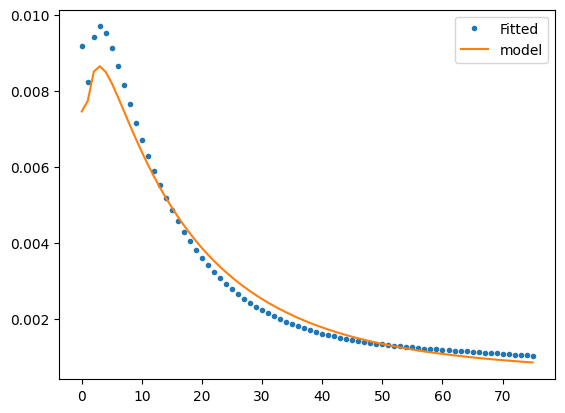

In [ ]:
a_desc = a_current.reshape((P+1, Q+1))
C_desc = np.zeros((nell, nf))
for p in range(P + 1):
    for q in range(Q + 1):
        C_desc += (a_desc[p, q]) * np.outer(log_l**p, Psi[q])



plt.plot( C_desc[:,14], '.',label='Fitted')
plt.plot( C_fit_diag[:,14], label='model')
plt.legend()

Dual annealing scipy

In [646]:
from scipy.optimize import dual_annealing

a_init = 2 * a_vec  
margin_factor = 5  # search ±5× the absolute value
min_range = 1e-10     # ensure small values still get some room

bounds = []
for val in a_init:
    span = max(abs(val) * margin_factor, min_range)
    bounds.append((val - span, val + span))

# Initial guess (optional)
x0 = 2 * a_vec  

# Run dual_annealing
result_ann = dual_annealing(loss, x0=x0, bounds=bounds, maxiter=1000)

a_ann = result_ann.x.reshape((P + 1, Q + 1))
print("Optimal loss:", result_ann.fun)


Optimal loss: 0.0014739967344593796


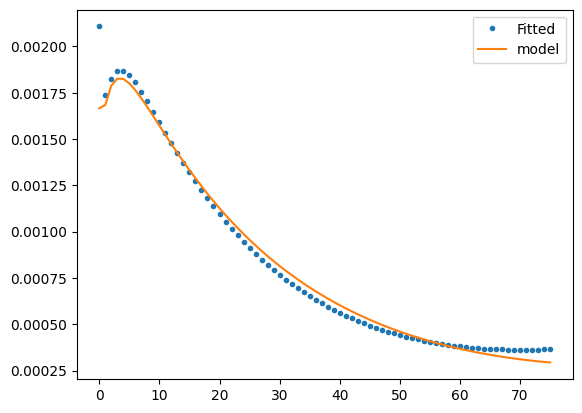

In [647]:
C_ann = np.zeros((nell, nf))
for p in range(P + 1):
    for q in range(Q + 1):
        C_ann += (a_ann[p, q]) * np.outer(log_l**p, Psi[q])
# C_mse_fit *=np.linalg.norm(C_fit_diag)

# mse = np.mean((C_mse_fit - C_fit_diag/np.linalg.norm(C_fit_diag))**2)
# print(f"MSE: {mse:.3e}")
plt.plot( C_ann[:,42], '.',label='Fitted')
plt.plot( C_fit_diag[:,42], label='model')
# plt.plot( C_diag[:,23], label='True')
plt.legend()

In [648]:
a_loc = a_ann.flatten()

In [649]:
from scipy.optimize import minimize

res5 = minimize(loss,a_loc,
            #    jac=grad_loss,
               method='L-BFGS-B',
               options={'disp': True, 'maxls':10000,'ftol': 1e-30,'gtol': 1e-30, 'maxiter': 50000}) #, 'maxls':100,'xtol': 1e-15, 'gtol': 1e-15, 'verbose': 2

a_opt5 = res5.x.reshape((P+1, Q+1))

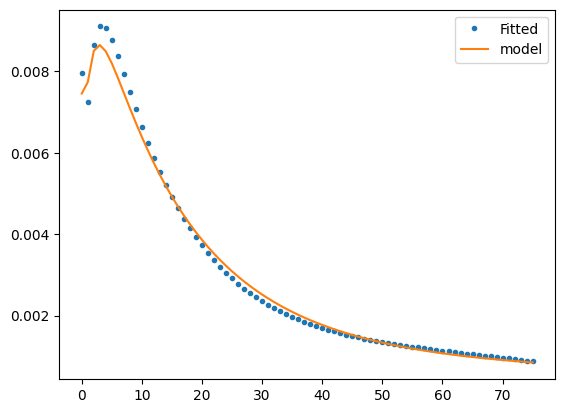

In [650]:
C_loc = np.zeros((nell, nf))
for p in range(P + 1):
    for q in range(Q + 1):
        C_loc += (a_opt5[p, q]) * np.outer(log_l**p, Psi[q])
# C_mse_fit *=np.linalg.norm(C_fit_diag)

# mse = np.mean((C_mse_fit - C_fit_diag/np.linalg.norm(C_fit_diag))**2)
# print(f"MSE: {mse:.3e}")
plt.plot( C_loc[:,15], '.',label='Fitted')
plt.plot( C_fit_diag[:,15], label='model')
# plt.plot( C_diag[:,23], label='True')
plt.legend()

In [651]:
s[0]/s[-1]

np.float64(471256.10212028545)

In [652]:
diff = a_opt5.flatten() - a_vec
print("Max abs diff:", np.max(np.abs(diff)))
print("RMS diff:", np.sqrt(np.mean(diff**2)))


Max abs diff: 0.6420290215470621
RMS diff: 0.1822687506086075


Least squares

In [653]:
a_prior = 0*a_vec  # or your prior
lam = 1e-4 
A = X.T @ X + lam * np.eye(n_terms)
b = X.T @ y + lam * a_prior
a_map = np.linalg.solve(A, b)

In [654]:
diff = a_map.flatten() - a_vec
print("Max abs diff:", np.max(np.abs(diff)))
print("RMS diff:", np.sqrt(np.mean(diff**2)))

Max abs diff: 0.6480477231916583
RMS diff: 0.18257358702625237


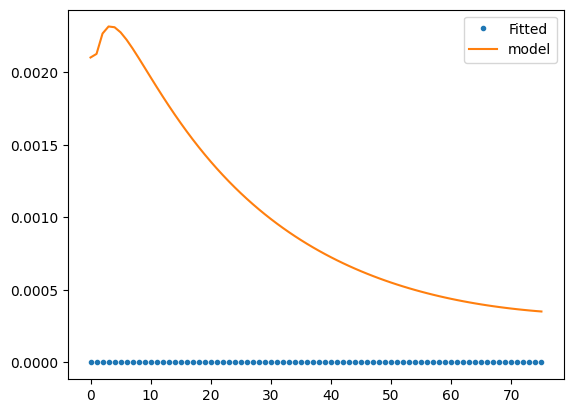

In [655]:
a_tk = a_map.reshape((P+1, Q+1))
C_tk = np.zeros((nell, nf))
for p in range(P + 1):
    for q in range(Q + 1):
        C_tk += (a_tk[p, q]) * np.outer(log_l**p, Psi[q])
# C_mse_fit *=np.linalg.norm(C_fit_diag)

# mse = np.mean((C_mse_fit - C_fit_diag/np.linalg.norm(C_fit_diag))**2)
# print(f"MSE: {mse:.3e}")
plt.plot( C_tk[:,35], '.',label='Fitted')
plt.plot( C_fit_diag[:,35], label='model')
# plt.plot( C_diag[:,35], label='True')
plt.legend()

In [656]:
import numpy as np

# Flatten target
y = C_fit_diag.reshape(-1)             # shape: (nell*nf,)

# Build design columns for each (p,q): vec( log_l^p ⊗ Psi[q] )
cols = []
for p in range(P+1):
    for q in range(Q+1):
        cols.append(np.outer(log_l**p, Psi[q]).reshape(-1))
X = np.column_stack(cols)              # shape: (nell*nf, (P+1)*(Q+1))

# Column scaling to reduce condition number
col_norms = np.linalg.norm(X, axis=0) + 1e-15
Xs = X / col_norms                     # scaled design


In [657]:
lam = 1e-10  # start tiny; increase if coefficients look wild (e.g., 1e-6 ~ 1e-3)

def loss_mse(theta):
    # a = theta / col_norms, but we can stay in scaled space:
    r = Xs @ theta - y
    return 0.5 * np.dot(r, r) + 0.5 * lam * np.dot(theta, theta)

def grad_mse(theta):
    r = Xs @ theta - y
    return Xs.T @ r + lam * theta


In [658]:
from scipy.optimize import minimize

# Start from your guess a_vec but map to scaled space
theta0 = ( 2*a_vec) * col_norms    # because theta = a * col_norms

res = minimize(
    loss_mse, theta0,
    jac=grad_mse,
    method='L-BFGS-B',                 # or 'CG' if you prefer
    options={'maxiter': 2000, 'gtol': 1e-10, 'ftol': 1e-12, 'disp': True}
)

theta_opt = res.x
a_opt = (theta_opt / col_norms).reshape((P+1, Q+1))


In [659]:
diff = a_opt.flatten() - a_vec
print("Max abs diff:", np.max(np.abs(diff)))
print("RMS diff:", np.sqrt(np.mean(diff**2)))

Max abs diff: 0.7176193093159418
RMS diff: 0.20352976951774138


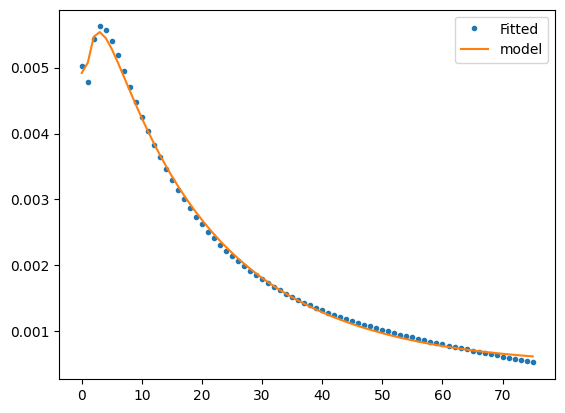

In [660]:
# a_ = a_map.reshape((P+1, Q+1))
C_mse = np.zeros((nell, nf))
for p in range(P + 1):
    for q in range(Q + 1):
        C_mse += (a_opt[p, q]) * np.outer(log_l**p, Psi[q])
# C_mse_fit *=np.linalg.norm(C_fit_diag)

# mse = np.mean((C_mse_fit - C_fit_diag/np.linalg.norm(C_fit_diag))**2)
# print(f"MSE: {mse:.3e}")
plt.plot( C_mse[:,23], '.',label='Fitted')
plt.plot( C_fit_diag[:,23], label='model')
# plt.plot( C_diag[:,23], label='True')
plt.legend()

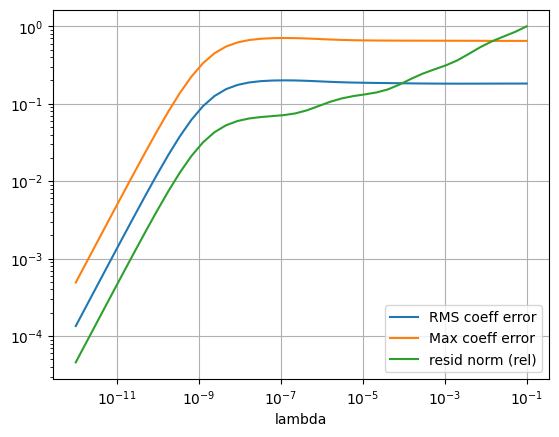

Best lambda by RMS error: 1e-12


In [661]:
def ridge_solve(Xs, y, lam):
    A = Xs.T @ Xs + lam * np.eye(Xs.shape[1])
    b = Xs.T @ y
    theta = np.linalg.solve(A, b)
    a = theta / col_norms
    return theta, a

lams = np.logspace(-12, -1, 40)
rms_err = []
max_err = []
resid_norm = []
for lam in lams:
    theta, a_r = ridge_solve(Xs, y, lam)
    diff = a_r - a_vec
    rms_err.append(np.sqrt(np.mean(diff**2)))
    max_err.append(np.max(np.abs(diff)))
    resid_norm.append(np.linalg.norm(X @ a_r - y))

# plot metrics
plt.loglog(lams, rms_err, label='RMS coeff error')
plt.loglog(lams, max_err, label='Max coeff error')
plt.loglog(lams, np.array(resid_norm)/np.max(resid_norm), label='resid norm (rel)')
plt.xlabel('lambda'); plt.legend(); plt.grid(True)
plt.show()

best_idx = int(np.argmin(rms_err))
print("Best lambda by RMS error:", lams[best_idx])


In [662]:
# try several k
ks = list(range(1, n_terms+1))
rms_err_tsvd = []
for k in range(1, n_terms+1):
    Uk = U[:, :k]; sk = s[:k]; Vk = Vt[:k, :]
    theta_tsvd = Vk.T @ ( (Uk.T @ y) / sk )
    a_tsvd = theta_tsvd / col_norms
    diff = a_tsvd - a_vec
    rms_err_tsvd.append(np.sqrt(np.mean(diff**2)))

plt.semilogy(range(1, n_terms+1), rms_err_tsvd)
plt.xlabel('k (kept singular vectors)')
plt.ylabel('RMS coeff error')
plt.show()


NameError: name 'Vt' is not defined

Residual norm: 1.0644110032255275e-07


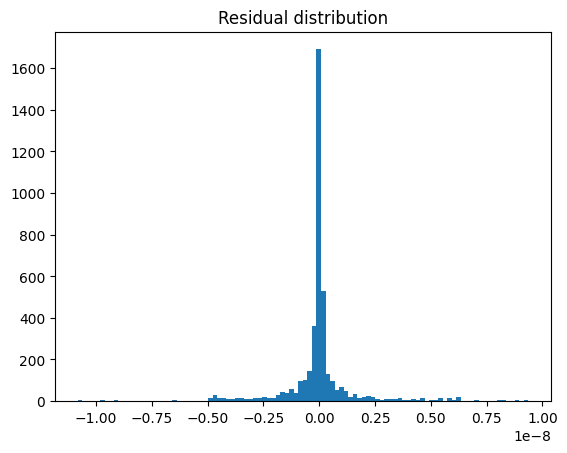

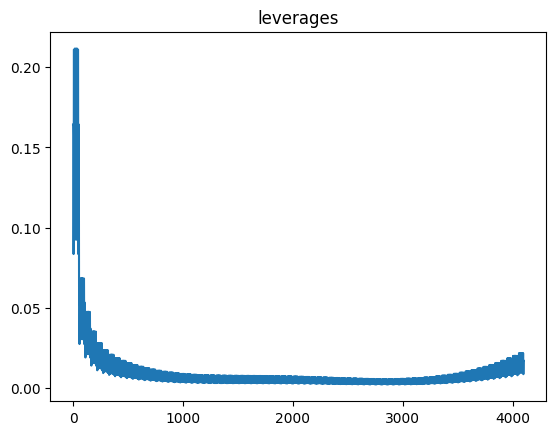

In [ ]:
theta_opt, a_opt = ridge_solve(Xs, y, lam=1e-6)  # tweak lam
resid = X @ a_opt - y
print("Residual norm:", np.linalg.norm(resid))
plt.hist(resid, bins=100); plt.title('Residual distribution'); plt.show()

# leverage / influence diag of H = X(X^T X + lam I)^{-1} X^T
Ainv = np.linalg.inv(Xs.T @ Xs + 1e-6*np.eye(n_terms))
H = Xs @ Ainv @ Xs.T
leverages = np.clip(np.diag(H), 0, 1)
plt.plot(leverages); plt.title('leverages'); plt.show()


In [ ]:
import numpy as np

def simulated_annealing(loss_func, a_init, steps=50000, T_init=1.0, T_min=1e-16, alpha=0.99, step_size=1e-8):
    a_current = a_init.copy()
    loss_current = loss_func(a_current)
    a_best = a_current.copy()
    loss_best = loss_current
    T = T_init

    for i in range(steps):
        # Propose random perturbation (Gaussian noise)
        a_new = a_current + step_size * np.random.randn(*a_current.shape)
        loss_new = loss_func(a_new)

        # Accept if better
        if loss_new < loss_current:
            a_current = a_new
            loss_current = loss_new
            if loss_new < loss_best:
                a_best = a_new
                loss_best = loss_new
        else:
            # Accept with probability exp(-(loss_new - loss_current)/T)
            prob = np.exp(-(loss_new - loss_current) / T)
            if np.random.rand() < prob:
                a_current = a_new
                loss_current = loss_new

        # Decrease temperature
        T = max(T * alpha, T_min)

        # Print progress every 1000 steps
        if i % 1000 == 0:
            print(f"Step {i}, Loss = {loss_current:.6e}, Best loss = {loss_best:.6e}, Temperature = {T:.3e}")

    return a_best, loss_best

# Example usage:
a_init = 2 * a_vec  # your initial guess flattened
a_sim_ann, loss_opt = simulated_annealing(loss, a_init, steps=50000, T_init=1.0, alpha=0.5, step_size=1e-10)


Step 0, Loss = 3.440667e-12, Best loss = 2.743760e-12, Temperature = 5.000e-01
Step 1000, Loss = 2.502196e-12, Best loss = 2.502196e-12, Temperature = 1.000e-16
Step 2000, Loss = 2.484002e-12, Best loss = 2.484002e-12, Temperature = 1.000e-16
Step 3000, Loss = 2.460339e-12, Best loss = 2.460339e-12, Temperature = 1.000e-16
Step 4000, Loss = 2.421651e-12, Best loss = 2.421651e-12, Temperature = 1.000e-16
Step 5000, Loss = 2.397024e-12, Best loss = 2.397024e-12, Temperature = 1.000e-16
Step 6000, Loss = 2.397024e-12, Best loss = 2.397024e-12, Temperature = 1.000e-16
Step 7000, Loss = 2.379427e-12, Best loss = 2.379427e-12, Temperature = 1.000e-16
Step 8000, Loss = 2.350335e-12, Best loss = 2.350335e-12, Temperature = 1.000e-16
Step 9000, Loss = 2.350335e-12, Best loss = 2.350335e-12, Temperature = 1.000e-16
Step 10000, Loss = 2.350335e-12, Best loss = 2.350335e-12, Temperature = 1.000e-16
Step 11000, Loss = 2.332543e-12, Best loss = 2.332543e-12, Temperature = 1.000e-16
Step 12000, Loss 

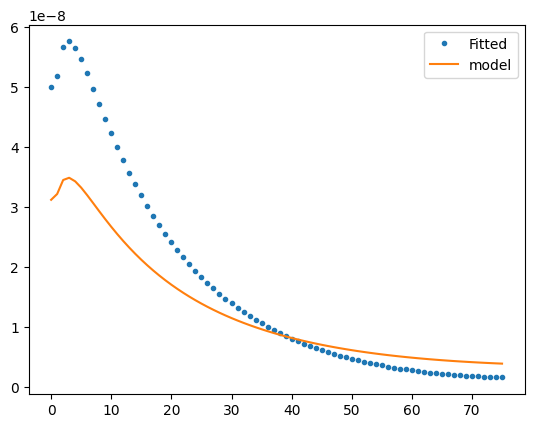

In [ ]:
a_sim_ann= a_current.reshape((P+1, Q+1))
C_sim_ann = np.zeros((nell, nf))
for p in range(P + 1):
    for q in range(Q + 1):
        C_sim_ann += (a_sim_ann[p, q]) * np.outer(log_l**p, Psi[q])
# C_mse_fit *=np.linalg.norm(C_fit_diag)

# mse = np.mean((C_mse_fit - C_fit_diag/np.linalg.norm(C_fit_diag))**2)
# print(f"MSE: {mse:.3e}")
plt.plot( C_sim_ann[:,23], '.',label='Fitted')
plt.plot( C_fit_diag[:,23], label='model')
# plt.plot( C_diag[:,20], label='True')
plt.legend()

Model 4

In [ ]:
# from itertools import product
# from numpy.linalg import lstsq

# P_4, Q_4 = 5,5  #degree

# # Step 1: Extract diagonal
# nell, nf, _ = hi_d.shape
# C_diag_4 = np.array([np.diag(hi_d[i]) for i in range(nell)])  # shape (nell, nf)

# # Step 2: Log coordinates
# log_l = np.log10(leff)  # shape (nell,)
# log_v = np.log10(freqs[:-1])  # shape (nf,)

# # Step 3: Build coeff matrix
# basis_terms_4 = list(product(range(P_4 + 1), range(Q_4 + 1))) # all (p, q) pairs (0,0), (0,1), ..., (P,Q)
# n_terms_4 = len(basis_terms_4) # total number of basis functions (P + 1) * (Q + 1)

# X_4 = np.zeros((nell * nf, n_terms_4))# rows = data points, cols = basis terms
# y_4 = C_diag_4.reshape(-1) #flatten target values to shape (nell * nf,)

# for i, (p, q) in enumerate(basis_terms_4):
#     # Outer product: (nell,) x (nf,) → shape (nell, nf)
#     X_4[:, i] = np.outer(log_l**p, log_v**q).reshape(-1)

# # Step 4: Solve least mean squares
# a_vec_4, residuals_4, rank_4, s_4 = lstsq(X_4, y_4, rcond=None)
# a_matrix_4 = a_vec_4.reshape((P_4 + 1, Q_4 + 1))  # shape (P+1, Q+1)

# # Step 5: Reconstruct the fitted diagonal
# C_fit_diag_4 = np.zeros((nell, nf))
# for p in range(P_4 + 1):
#     for q in range(Q_4 + 1):
#         C_fit_diag_4 += a_matrix_4[p, q] * np.outer(log_l**p, log_v**q)

# # Step 6: Expand to full (nell, nf, nf) with diagonal only
# C_fit_4 = np.zeros((nell, nf, nf))
# for i in range(nell):
#     np.fill_diagonal(C_fit_4[i], C_fit_diag_4[i])


In [ ]:
# from scipy.optimize import dual_annealing

# a_init_4 = 2 * a_vec_4 
# margin = 10
# bounds = [(val - margin, val + margin) for val in a_init_4]

# # Initial guess (optional, dual_annealing can pick internally)
# x0 = 2 * a_vec_4  

# # Run dual_annealing
# result_ann_4 = dual_annealing(loss, x0=x0, bounds=bounds, maxiter=3000)

# a_ann_4 = result_ann_4.x.reshape((P + 1, Q + 1))
# print("Optimal loss:", result_ann_4.fun)


In [ ]:
# # a_desc = a_current.reshape((P+1, Q+1))
# C_ann_4 = np.zeros((nell, nf))
# for p in range(P + 1):
#     for q in range(Q + 1):
#         C_ann_4 += (a_ann_4[p, q]) * np.outer(log_l**p, Psi[q])
# # C_mse_fit *=np.linalg.norm(C_fit_diag)

# # mse = np.mean((C_mse_fit - C_fit_diag/np.linalg.norm(C_fit_diag))**2)
# # print(f"MSE: {mse:.3e}")
# plt.plot( C_ann_4[:,23], '.',label='Fitted')
# plt.plot( C_fit_diag[:,23], label='model')
# # plt.plot( C_diag[:,20], label='True')
# plt.legend()